# Training a U-net Model from Scratch 

# Loading The Data

import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torch.nn.functional import relu
import pydicom
from PIL import Image
import numpy as np
from torchsummary import summary
import torch.nn.functional as F



First, I need to make a data structure that contains pairs of an image along with its binary masks. 


In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import pydicom
from PIL import Image
import numpy as np
from torchsummary import summary
import torch.nn.functional as F
import seaborn as sns


In [2]:
root_dir = "mask_and_mri_training"

data = []  # List to store image-masks pairs

# Iterate over patient directories in mask_and_mri
for patient_dir in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_dir)
    if os.path.isdir(patient_path):
        images_dir = os.path.join(patient_path, "images")
        masks_dir = os.path.join(patient_path, "masks")
        
        # Iterate over image files
        for image_file in os.listdir(images_dir):
            if image_file.endswith(".dcm"):
                image_path = os.path.join(images_dir, image_file)
                
                # Extract image ID
                image_id = image_file[:-4]  # Remove extension
                
                # Find corresponding masks
                masks = []
                for mask_file in os.listdir(masks_dir):
                    if image_id in mask_file:
                        mask_path = os.path.join(masks_dir, mask_file)
                        # makes a one to one mapping for masks and their image
                        data.append((mask_path,image_path))
                

# Print first few entries for verification
for i in range(30):
    print(data[i])
    
print(len(data))

('mask_and_mri_training\\SC-HF-I-01\\masks\\IM-0001-0048_icontour_1_mask.png', 'mask_and_mri_training\\SC-HF-I-01\\images\\IM-0001-0048.dcm')
('mask_and_mri_training\\SC-HF-I-01\\masks\\IM-0001-0059_icontour_1_mask.png', 'mask_and_mri_training\\SC-HF-I-01\\images\\IM-0001-0059.dcm')
('mask_and_mri_training\\SC-HF-I-01\\masks\\IM-0001-0059_ocontour_1_mask.png', 'mask_and_mri_training\\SC-HF-I-01\\images\\IM-0001-0059.dcm')
('mask_and_mri_training\\SC-HF-I-01\\masks\\IM-0001-0068_icontour_1_mask.png', 'mask_and_mri_training\\SC-HF-I-01\\images\\IM-0001-0068.dcm')
('mask_and_mri_training\\SC-HF-I-01\\masks\\IM-0001-0079_icontour_1_mask.png', 'mask_and_mri_training\\SC-HF-I-01\\images\\IM-0001-0079.dcm')
('mask_and_mri_training\\SC-HF-I-01\\masks\\IM-0001-0079_ocontour_1_mask.png', 'mask_and_mri_training\\SC-HF-I-01\\images\\IM-0001-0079.dcm')
('mask_and_mri_training\\SC-HF-I-01\\masks\\IM-0001-0088_icontour_1_mask.png', 'mask_and_mri_training\\SC-HF-I-01\\images\\IM-0001-0088.dcm')
('mask

In [3]:
root_dir = "mask_and_mri_validation"

data_validation = []  # List to store image-masks pairs

# Iterate over patient directories in mask_and_mri
for patient_dir in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_dir)
    if os.path.isdir(patient_path):
        images_dir = os.path.join(patient_path, "images")
        masks_dir = os.path.join(patient_path, "masks")
        
        # Iterate over image files
        for image_file in os.listdir(images_dir):
            if image_file.endswith(".dcm"):
                image_path = os.path.join(images_dir, image_file)
                
                # Extract image ID
                image_id = image_file[:-4]  # Remove extension
                
                # Find corresponding masks
                masks = []
                for mask_file in os.listdir(masks_dir):
                    if image_id in mask_file:
                        mask_path = os.path.join(masks_dir, mask_file)
                        # makes a one to one mapping for masks and their image
                        data_validation.append((mask_path,image_path))
                

# Print first few entries for verification
for i in range(30):
    print(data_validation[i])
    
print(len(data_validation))

('mask_and_mri_validation\\SC-HF-I-05\\masks\\IM-0001-0027_icontour_1_mask.png', 'mask_and_mri_validation\\SC-HF-I-05\\images\\IM-0001-0027.dcm')
('mask_and_mri_validation\\SC-HF-I-05\\masks\\IM-0001-0040_icontour_1_mask.png', 'mask_and_mri_validation\\SC-HF-I-05\\images\\IM-0001-0040.dcm')
('mask_and_mri_validation\\SC-HF-I-05\\masks\\IM-0001-0040_ocontour_1_mask.png', 'mask_and_mri_validation\\SC-HF-I-05\\images\\IM-0001-0040.dcm')
('mask_and_mri_validation\\SC-HF-I-05\\masks\\IM-0001-0047_icontour_1_mask.png', 'mask_and_mri_validation\\SC-HF-I-05\\images\\IM-0001-0047.dcm')
('mask_and_mri_validation\\SC-HF-I-05\\masks\\IM-0001-0060_icontour_1_mask.png', 'mask_and_mri_validation\\SC-HF-I-05\\images\\IM-0001-0060.dcm')
('mask_and_mri_validation\\SC-HF-I-05\\masks\\IM-0001-0060_ocontour_1_mask.png', 'mask_and_mri_validation\\SC-HF-I-05\\images\\IM-0001-0060.dcm')
('mask_and_mri_validation\\SC-HF-I-05\\masks\\IM-0001-0060_p2contour_1_mask.png', 'mask_and_mri_validation\\SC-HF-I-05\\imag

# Visualization of a single image with a mask

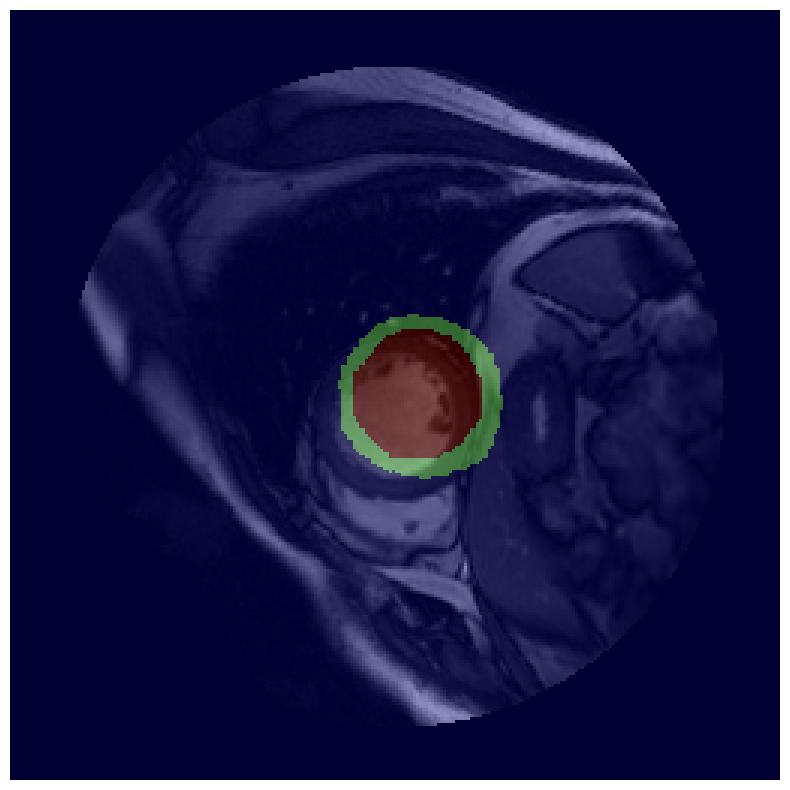

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# images and masks will follow similar preprocessing for normalization

image_path = 'C:\\Users\\Ashraf\\Desktop\\Automated Left Ventricular Segmentation\\mask_and_mri_training\\SC-HF-I-01\\images\\IM-0001-0119.dcm'
image = pydicom.dcmread(image_path).pixel_array
image = image.astype(np.float32) / image.max()
image = torch.from_numpy(image)
# Ensure image tensor is of type torch.float32
image = image.float()

# inner contour
mask_path1 = 'C:\\Users\\Ashraf\\Desktop\\Automated Left Ventricular Segmentation\\mask_and_mri_training\\SC-HF-I-01\\masks\\IM-0001-0119_icontour_1_mask.png'
mask1 = np.array(Image.open(mask_path1))
mask1 = mask1.astype(np.float32)  # Convert mask to float32
mask1= torch.from_numpy(mask1).float()  # Convert mask to PyTorch tensor

# outer contour
mask_path2 = 'C:\\Users\\Ashraf\\Desktop\\Automated Left Ventricular Segmentation\\mask_and_mri_training\\SC-HF-I-01\\masks\\IM-0001-0119_ocontour_1_mask.png'
mask2 = np.array(Image.open(mask_path2))
mask2 = mask2.astype(np.float32)  # Convert mask to float32
mask2 = torch.from_numpy(mask2).float()  # Convert mask to PyTorch tensor


plt.figure(figsize=(10, 10))

# Display the MRI image
plt.imshow(image, cmap='gray')  # MRI images are often visualized in grayscale

# Overlay the masks
# Combine masks by summing them
mask_combined = mask1 + mask2

plt.imshow(mask_combined, cmap='jet', alpha= 0.4)  # this does cause a blue tint due to the color map. but the MRI is greyscale
# using the jet cmap causes everything to become tinted blue because the masks contains 0s everywhere else except the pixels that have been identified as being part of the left ventricle



plt.axis('off')  # Optional: Remove axes for cleaner visualization
plt.show()


In [5]:

import torch
from torchvision.transforms import ToTensor

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        mask_path, image_path = self.data[idx]
        
        # Load mask
        mask = np.array(Image.open(mask_path))
        mask = mask.astype(np.float32)  # Convert mask to float32
        mask = torch.from_numpy(mask)  # Convert mask to PyTorch tensor
        
        
        # Load image
        image = pydicom.dcmread(image_path).pixel_array
        image = image.astype(np.float32) / image.max()
        
        # Ensure image tensor is of type torch.float32
        image = ToTensor()(image)
        
        return mask, image


dataset = CustomDataset(data)
dataset_valid = CustomDataset(data_validation)

# Create a DataLoader using your custom dataset
# I have gotten much better results from smaller batches
# The model seems to be better at predicting a good amount of 1s and 0s at this size
data_loader = DataLoader(dataset, batch_size=3, shuffle=True)   
data_loader_valid = DataLoader(dataset_valid, batch_size=3, shuffle=True)

num_batches_to_print = 3
# Iterate over the DataLoader to inspect its contents
for batch_idx, (mask, image) in enumerate(data_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"Number of masks: {len(image)}")
    print(f"Number of : {len(mask)}")
    print(f"Image shape: {image[0].shape}")  # Assuming images are of the same size
    print(f"Mask shape: {mask[0].shape}\n\n")    # Assuming masks are of the same size


    
print(len(data))
print(len(data_loader))
print(len(data_validation))
print(len(data_loader_valid))



Batch 1:
Number of masks: 3
Number of : 3
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 2:
Number of masks: 3
Number of : 3
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 3:
Number of masks: 3
Number of : 3
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 4:
Number of masks: 3
Number of : 3
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 5:
Number of masks: 3
Number of : 3
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 6:
Number of masks: 3
Number of : 3
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 7:
Number of masks: 3
Number of : 3
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 8:
Number of masks: 3
Number of : 3
Image shape: torch.Size([256, 256])
Mask shape: torch.Size([256, 256])


Batch 9:
Number of masks: 3
Number of : 3
Image shape: torch.Size([256, 256])
Ma

In [6]:
total_ones = 0
total_zeros = 0

for batch_idx, (masks, images) in enumerate(data_loader):
    for mask in masks:
        total_zeros += torch.sum(mask == 0)
        total_ones += torch.sum(mask == 1) 

average_pos = total_zeros / total_ones

print(average_pos)


tensor(57.5992)


# The Model

In [7]:
''' There are not many ways to build a simple/standard UNet architecture model for segmentation.
    However, I tried to learn as best I can about what the architecture looks like and what the parts of the model does and have come up with this.
    The Up class (decoders) which deals with upscaling the images is very similar to other decoders 
    I have seen while trying to see and learn from different variations of the architecture.
    There just isn't many ways to handle the skip connections and concatenations. 
    Some of the heaviest influences on this architecture are from the following :
    1. https://github.com/milesial/Pytorch-UNet/blob/master/unet/unet_parts.py
    2. https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3
    3. https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py   
'''

class UNet(nn.Module):
    def __init__(self, n_class=1):
        super(UNet, self).__init__()
        
        # Encoder
        self.inc = DoubleConv(1, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up1 = Up(1024, 512)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = Up(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3 = Up(256, 128)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up4 = Up(128, 64)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.upconv1(x5)
        x = self.up1(x, x4)
        x = self.upconv2(x)
        x = self.up2(x, x3)
        x = self.upconv3(x)
        x = self.up3(x, x2)
        x = self.upconv4(x)
        x = self.up4(x, x1)

        logits = self.outconv(x)
        return logits

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# downscaling 
class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

# upscaling 
# this upscaling class is similar to other upscaling classes for UNet. 
# Besides upscaling the image tensors, this class also has the skip connections for preserving spatial information
class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv = DoubleConv(in_channels, out_channels)

    # The input tensors have: channel, height, width
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


In [9]:
# pass an image through the model to see if it errors

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the UNet model
model = UNet()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
input_shape = (1, 256, 256)
summary(model,input_shape)

Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [-1, 64, 256, 256]        --
|    └─Sequential: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        640
|    |    └─BatchNorm2d: 3-2             [-1, 64, 256, 256]        128
|    |    └─LeakyReLU: 3-3               [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 256, 256]        36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 256, 256]        128
|    |    └─LeakyReLU: 3-6               [-1, 64, 256, 256]        --
├─Down: 1-2                              [-1, 128, 128, 128]       --
|    └─Sequential: 2-2                   [-1, 128, 128, 128]       --
|    |    └─MaxPool2d: 3-7               [-1, 64, 128, 128]        --
|    |    └─DoubleConv: 3-8              [-1, 128, 128, 128]       221,952
├─Down: 1-3                              [-1, 256, 64, 64]         --
|  

Layer (type:depth-idx)                   Output Shape              Param #
├─DoubleConv: 1-1                        [-1, 64, 256, 256]        --
|    └─Sequential: 2-1                   [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-1                  [-1, 64, 256, 256]        640
|    |    └─BatchNorm2d: 3-2             [-1, 64, 256, 256]        128
|    |    └─LeakyReLU: 3-3               [-1, 64, 256, 256]        --
|    |    └─Conv2d: 3-4                  [-1, 64, 256, 256]        36,928
|    |    └─BatchNorm2d: 3-5             [-1, 64, 256, 256]        128
|    |    └─LeakyReLU: 3-6               [-1, 64, 256, 256]        --
├─Down: 1-2                              [-1, 128, 128, 128]       --
|    └─Sequential: 2-2                   [-1, 128, 128, 128]       --
|    |    └─MaxPool2d: 3-7               [-1, 64, 128, 128]        --
|    |    └─DoubleConv: 3-8              [-1, 128, 128, 128]       221,952
├─Down: 1-3                              [-1, 256, 64, 64]         --
|  

In [10]:
# as of now this function is not good. Will revise soon



# def dice_coefficient(predicted, target, smooth=1e-6):
#     predicted_flat = predicted.view(-1)
#     target_flat = target.view(-1)
    
#     intersection = torch.sum(predicted_flat * target_flat)
#     union = torch.sum(predicted_flat) + torch.sum(target_flat)
    
#     dice = (2.0 * intersection + smooth) / (union + smooth)
#     return 1 - dice

In [11]:
num_epochs = 300  
loss_threshold = 0.6  # should be as close to 0 as possible. The amoint of 1s is still small
                        # The val loss doen't seem to get as low as the training loss
                        # this could be due to the model not training off of sufficient data.
                        # as of now without any data augmentation, the lowest the val loss gets is about 0.5266 

torch.manual_seed(101)
torch.cuda.manual_seed(101)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)  # AdamW optimizer seems to work extremely well
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience= 25, factor=0.1)
pos_weight = torch.tensor([average_pos]).to(device)  # Move pos_weight to device
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (masks, images) in enumerate(data_loader):
        images = images.to(device).unsqueeze(1)
        masks = masks.to(device).unsqueeze(1)

        # Forward pass
        outputs = model(images)
        
        # for my sanity
        # probabilities = torch.sigmoid(outputs)  # Apply sigmoid if your model outputs logits
        # predictions = (probabilities >= 0.5).float()  # Threshold the probabilities to get binary mask
        # print(torch.unique(predictions,return_counts=True))
        
        # Compute loss directly on outputs and masks
        loss = criterion(outputs, masks.float())

        # Zero gradients, backpropagate, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    train_loss = running_loss / len(data_loader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for masks, images in data_loader_valid:
            images = images.to(device).unsqueeze(1)
            masks = masks.to(device).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, masks.float())
            val_loss += loss.item() * images.size(0)

    val_loss /= len(data_loader_valid.dataset)
    scheduler.step(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Current lr = {optimizer.param_groups[0]['lr']}")

    if val_loss <= loss_threshold:
        print("Loss threshold reached. Saving the model.")
        torch.save(model.state_dict(), 'model.pth')
        break

# Print gradients
for name, param in model.named_parameters():
    if param.grad is not None:
        print(f'Gradient - {name}: {param.grad.norm()}')


Epoch [1/300], Train Loss: 0.2826, Val Loss: 0.1949, Current lr = 0.001
Loss threshold reached. Saving the model.
Gradient - inc.double_conv.0.weight: 0.00318028568290174
Gradient - inc.double_conv.0.bias: 1.9516405700414907e-06
Gradient - inc.double_conv.1.weight: 0.000746777281165123
Gradient - inc.double_conv.1.bias: 0.026232173666357994
Gradient - inc.double_conv.3.weight: 0.01246716734021902
Gradient - inc.double_conv.3.bias: 3.226538591860617e-09
Gradient - inc.double_conv.4.weight: 0.0015977829461917281
Gradient - inc.double_conv.4.bias: 0.00206792913377285
Gradient - down1.maxpool_conv.1.double_conv.0.weight: 0.006911488249897957
Gradient - down1.maxpool_conv.1.double_conv.0.bias: 1.0448197862444886e-10
Gradient - down1.maxpool_conv.1.double_conv.1.weight: 0.0006204462260939181
Gradient - down1.maxpool_conv.1.double_conv.1.bias: 0.0004978239303454757
Gradient - down1.maxpool_conv.1.double_conv.3.weight: 0.005399930756539106
Gradient - down1.maxpool_conv.1.double_conv.3.bias: 6.

35
(tensor([0., 1.], device='cuda:0'), tensor([60718,  4818], device='cuda:0'))


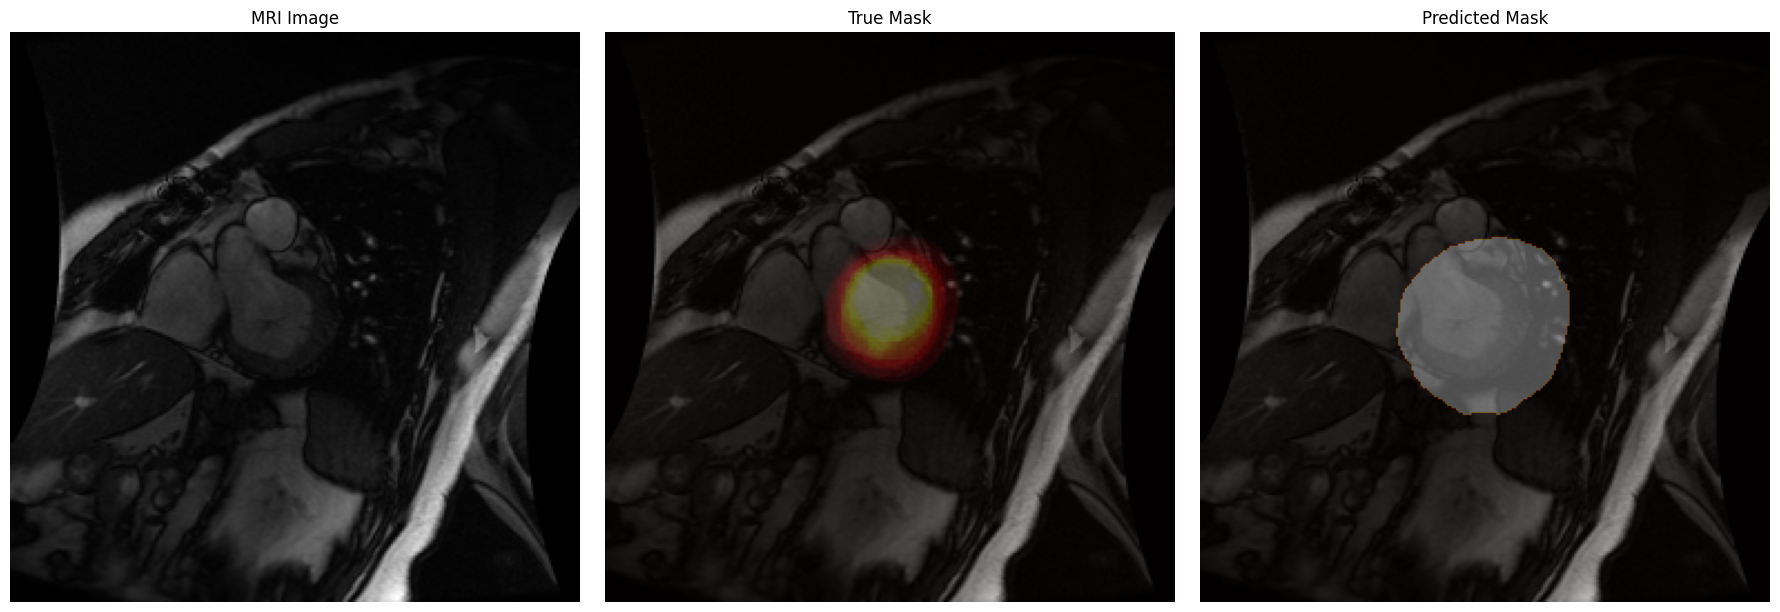

41
(tensor([0., 1.], device='cuda:0'), tensor([59928,  5608], device='cuda:0'))


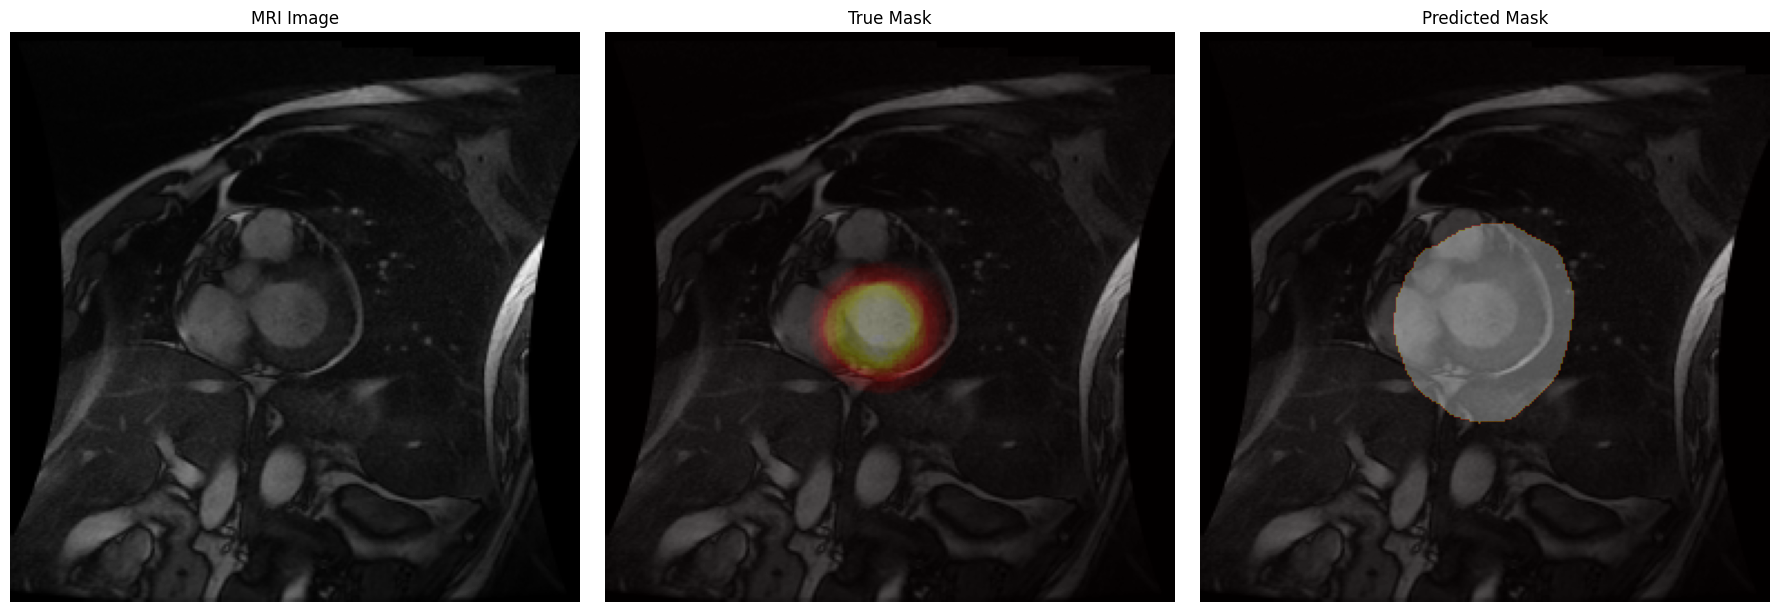

33
(tensor([0., 1.], device='cuda:0'), tensor([60510,  5026], device='cuda:0'))


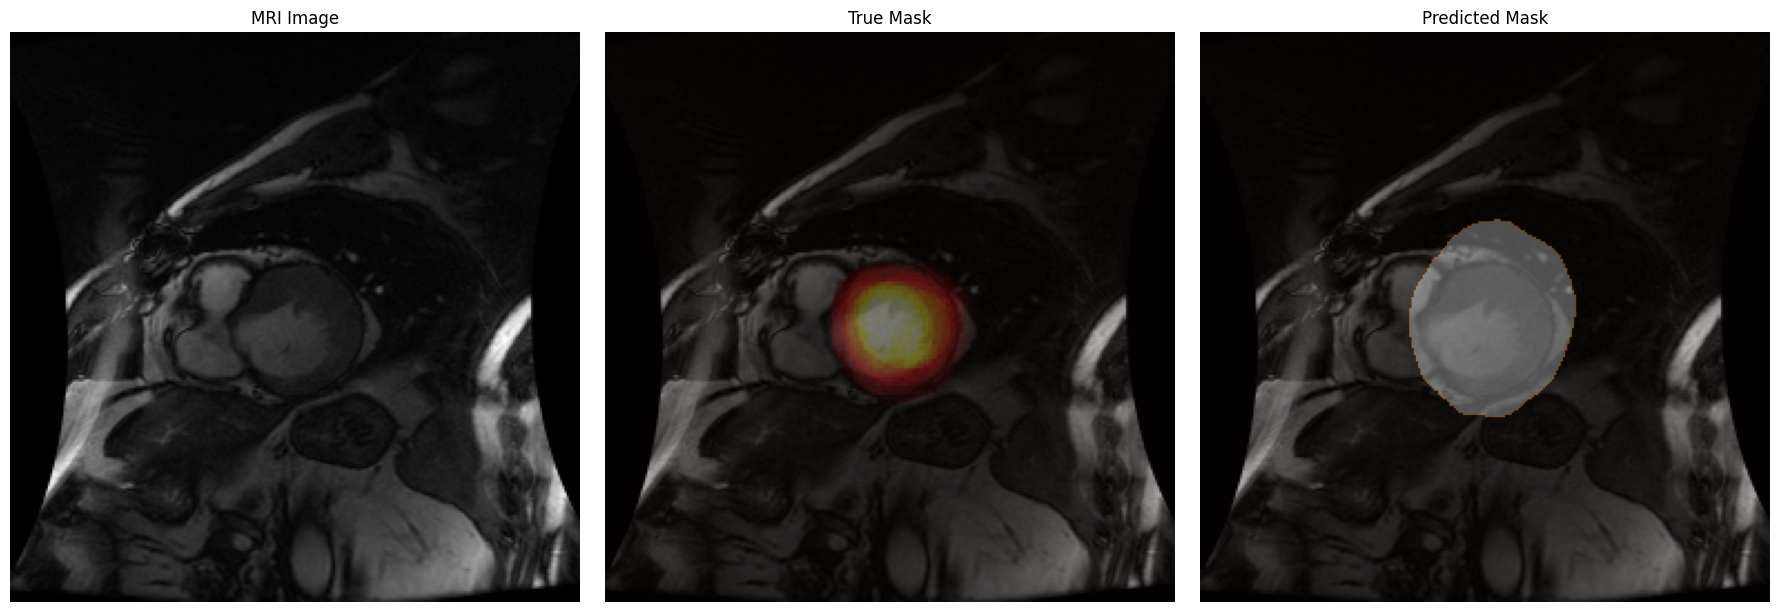

40
(tensor([0., 1.], device='cuda:0'), tensor([60202,  5334], device='cuda:0'))


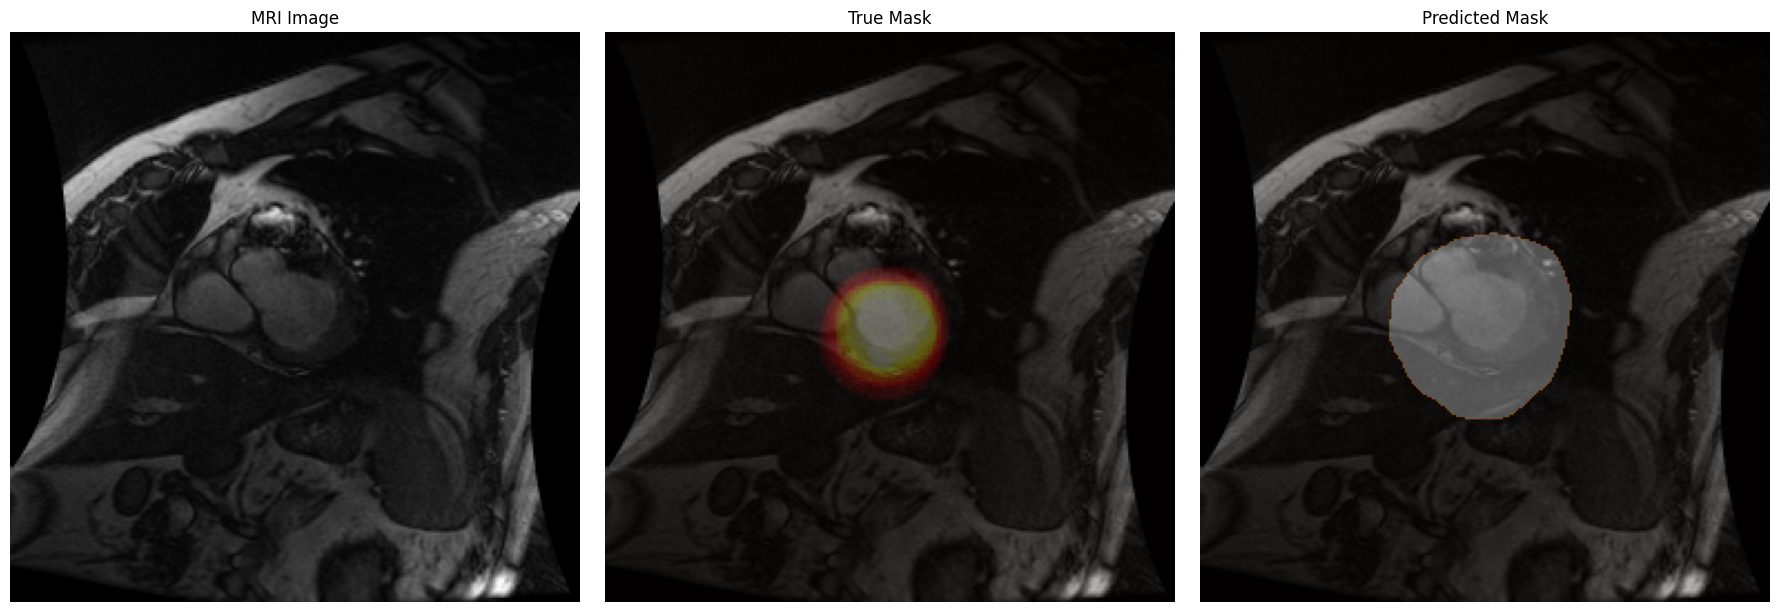

36
(tensor([0., 1.], device='cuda:0'), tensor([60061,  5475], device='cuda:0'))


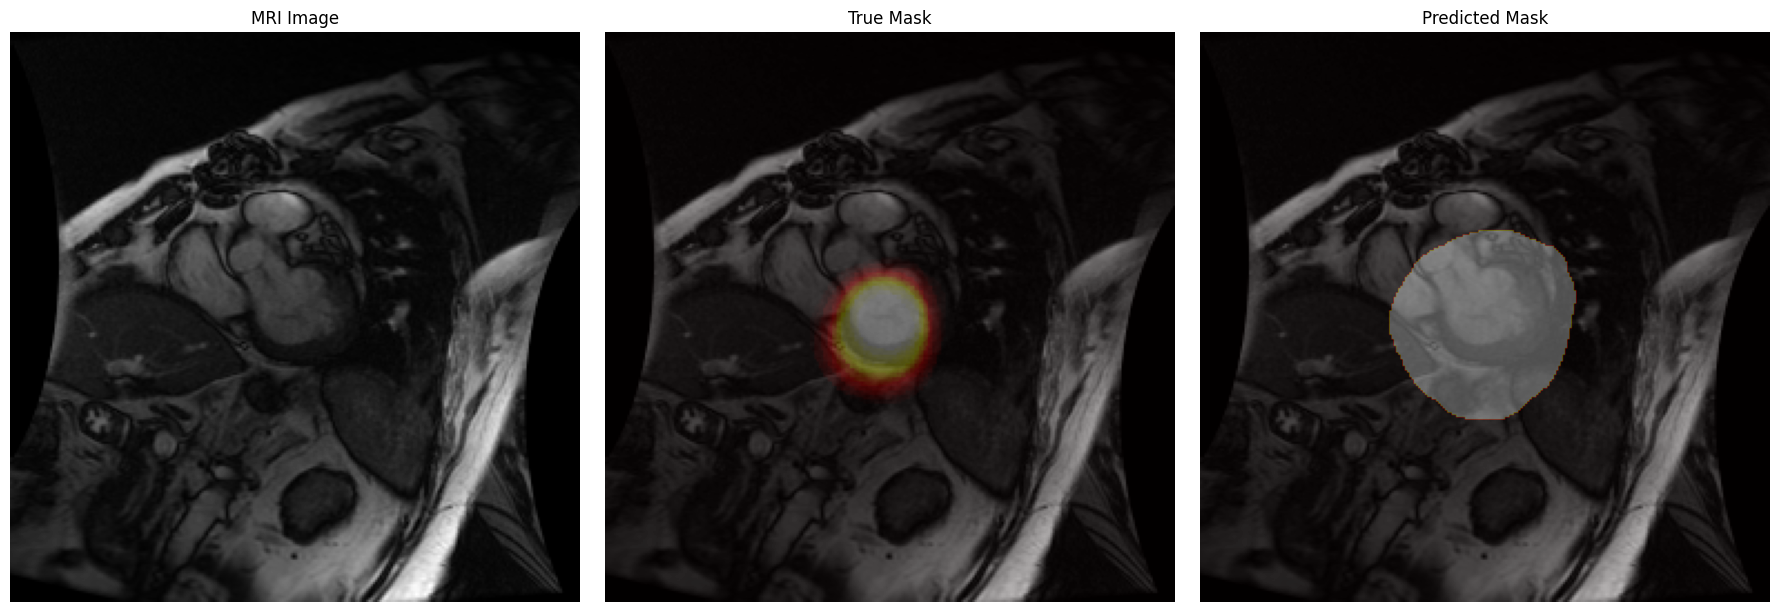

35
(tensor([0., 1.], device='cuda:0'), tensor([60089,  5447], device='cuda:0'))


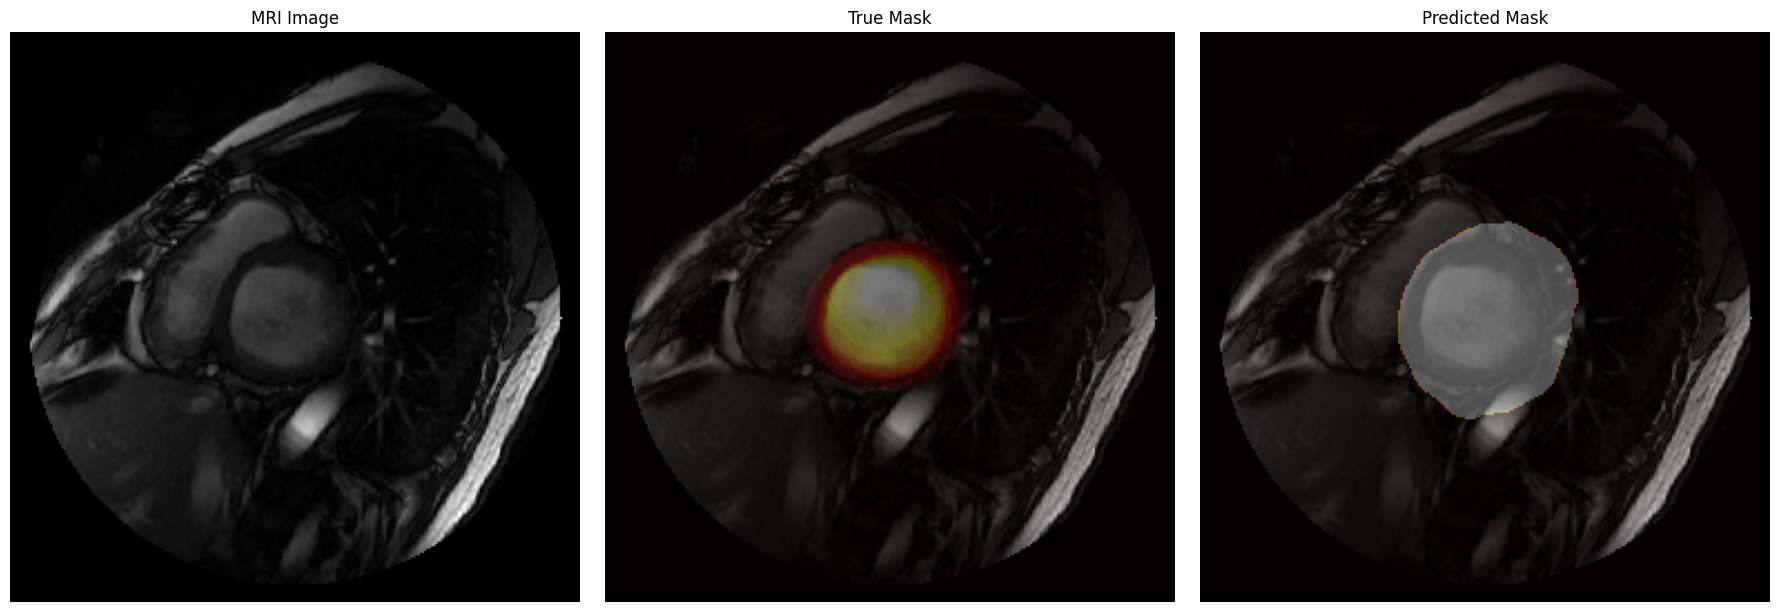

37
(tensor([0., 1.], device='cuda:0'), tensor([60797,  4739], device='cuda:0'))


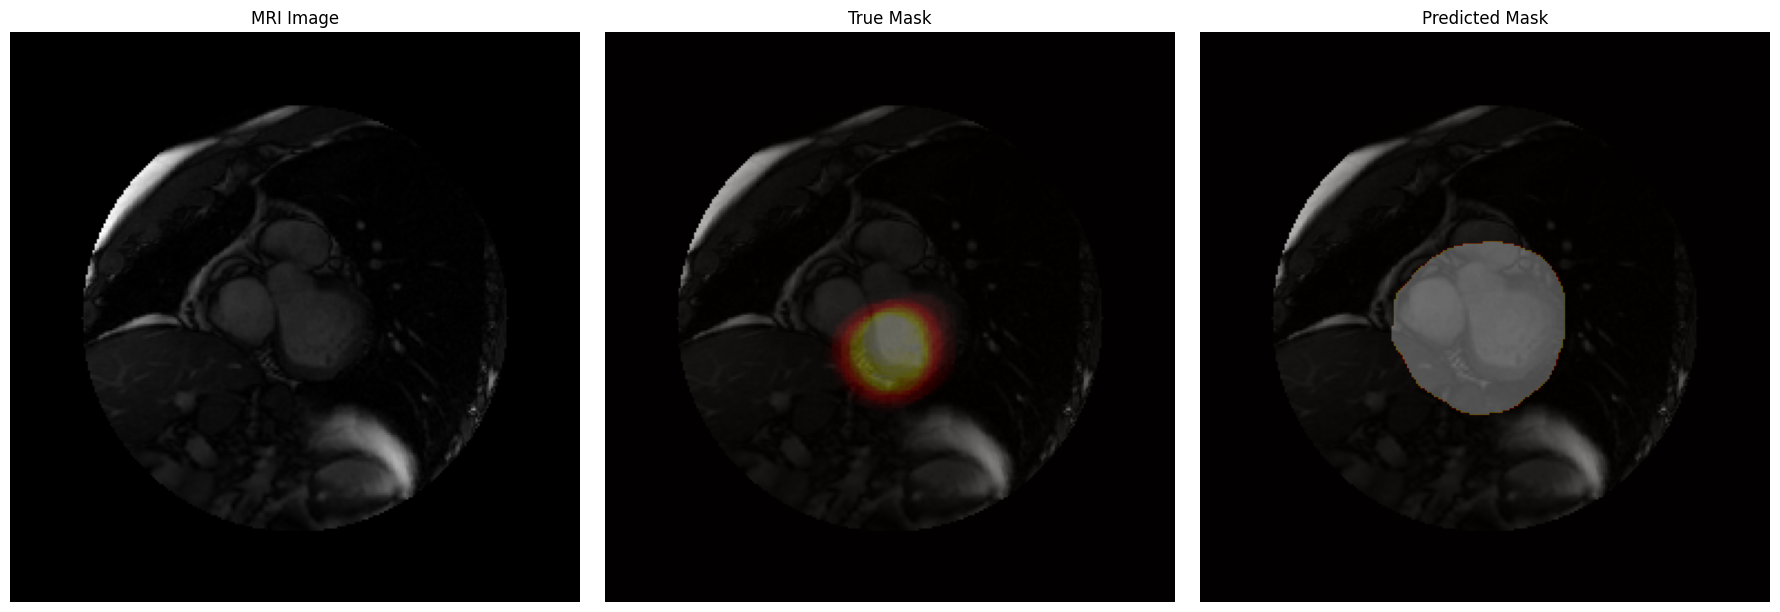

36
(tensor([0., 1.], device='cuda:0'), tensor([60786,  4750], device='cuda:0'))


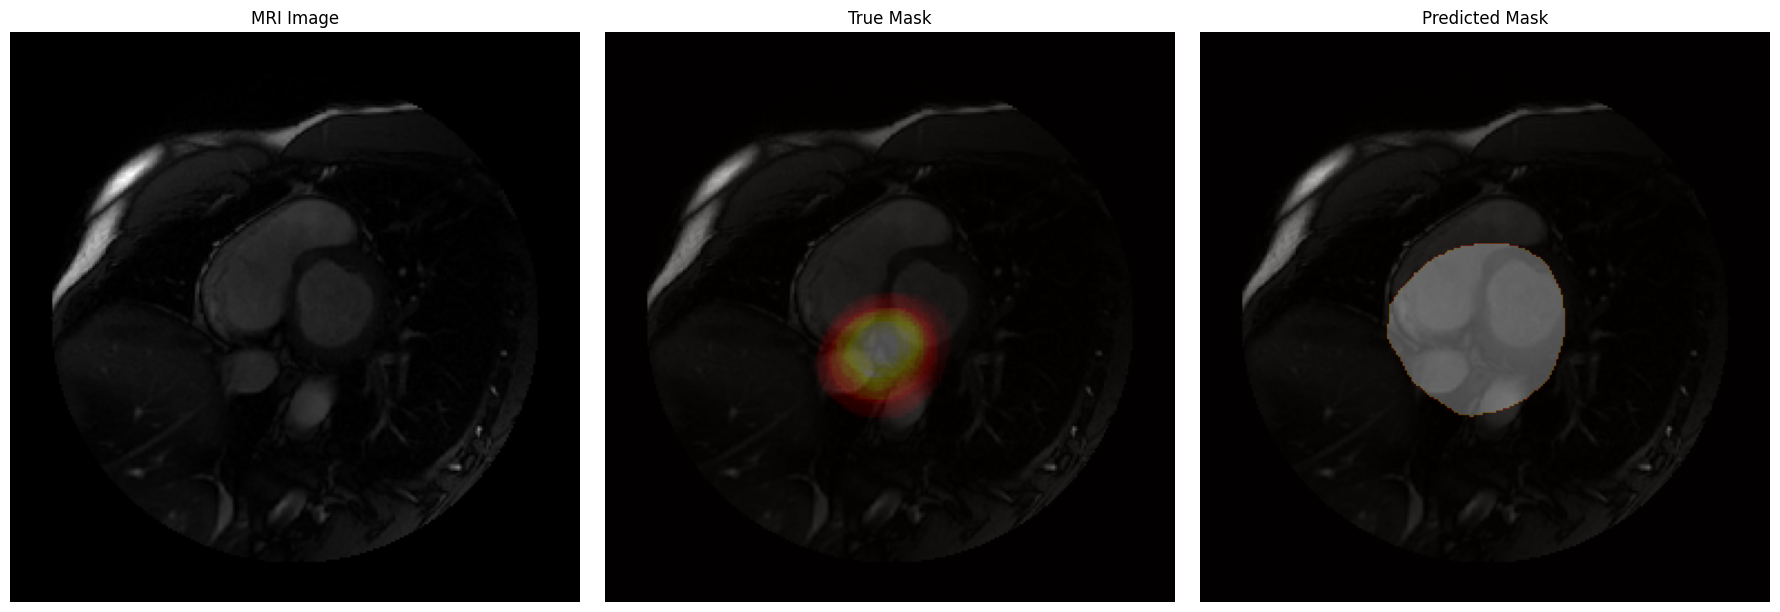

28
(tensor([0., 1.], device='cuda:0'), tensor([60889,  4647], device='cuda:0'))


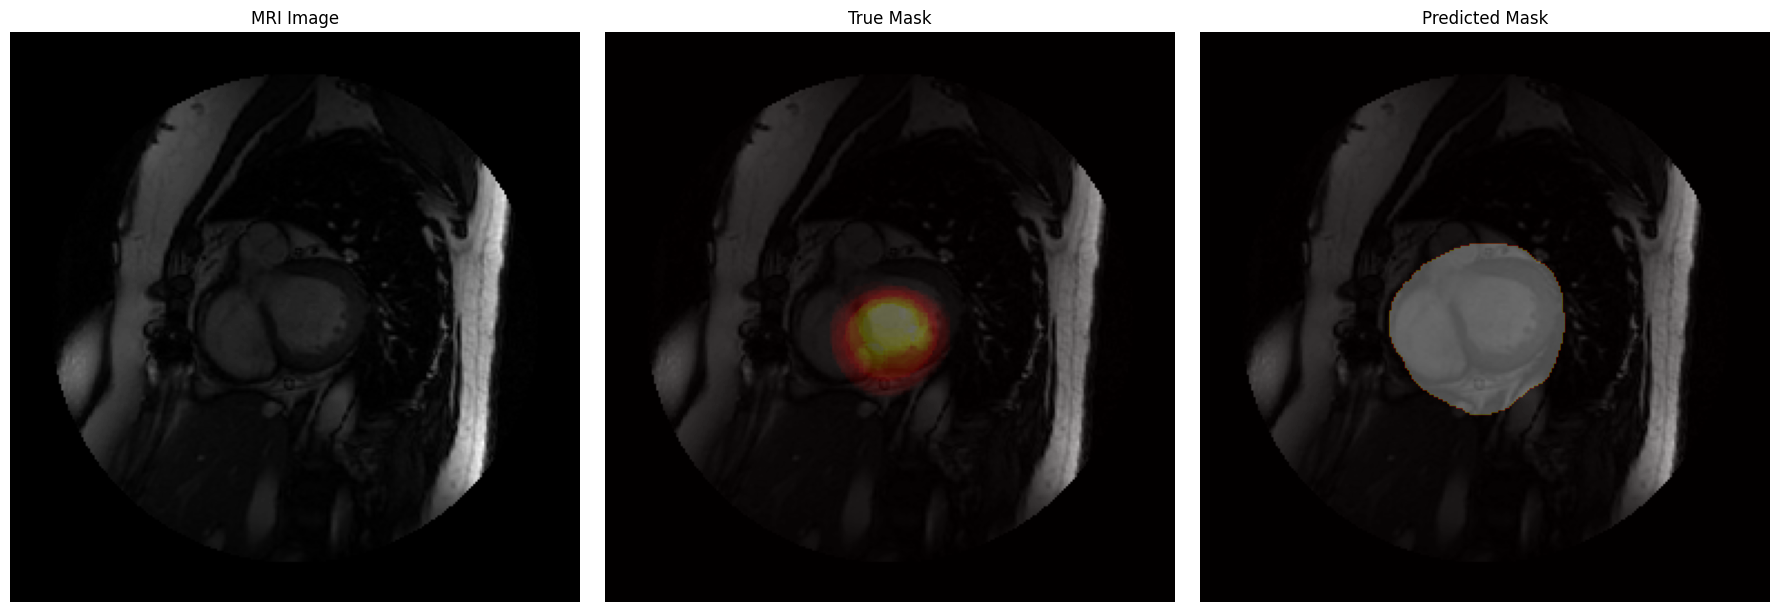

31
(tensor([0., 1.], device='cuda:0'), tensor([60991,  4545], device='cuda:0'))


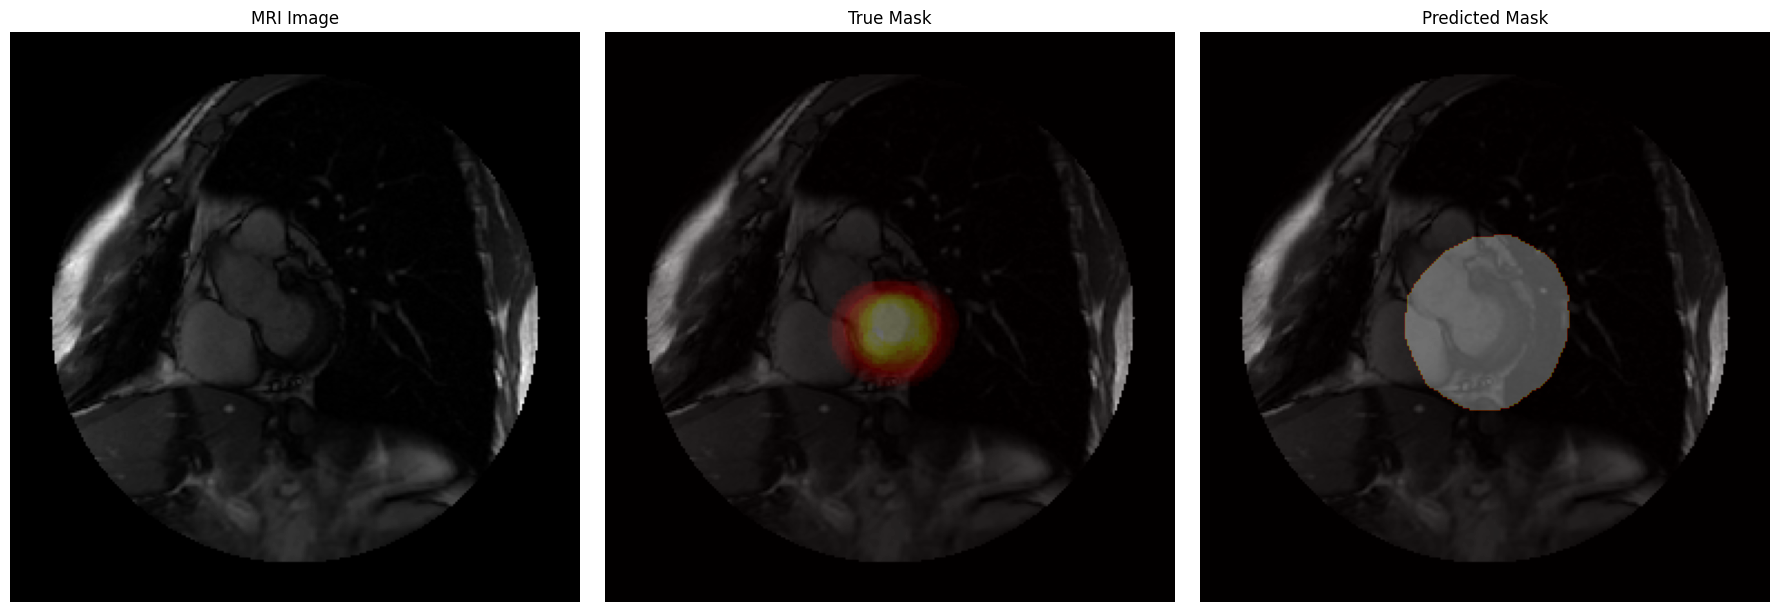

36
(tensor([0., 1.], device='cuda:0'), tensor([60965,  4571], device='cuda:0'))


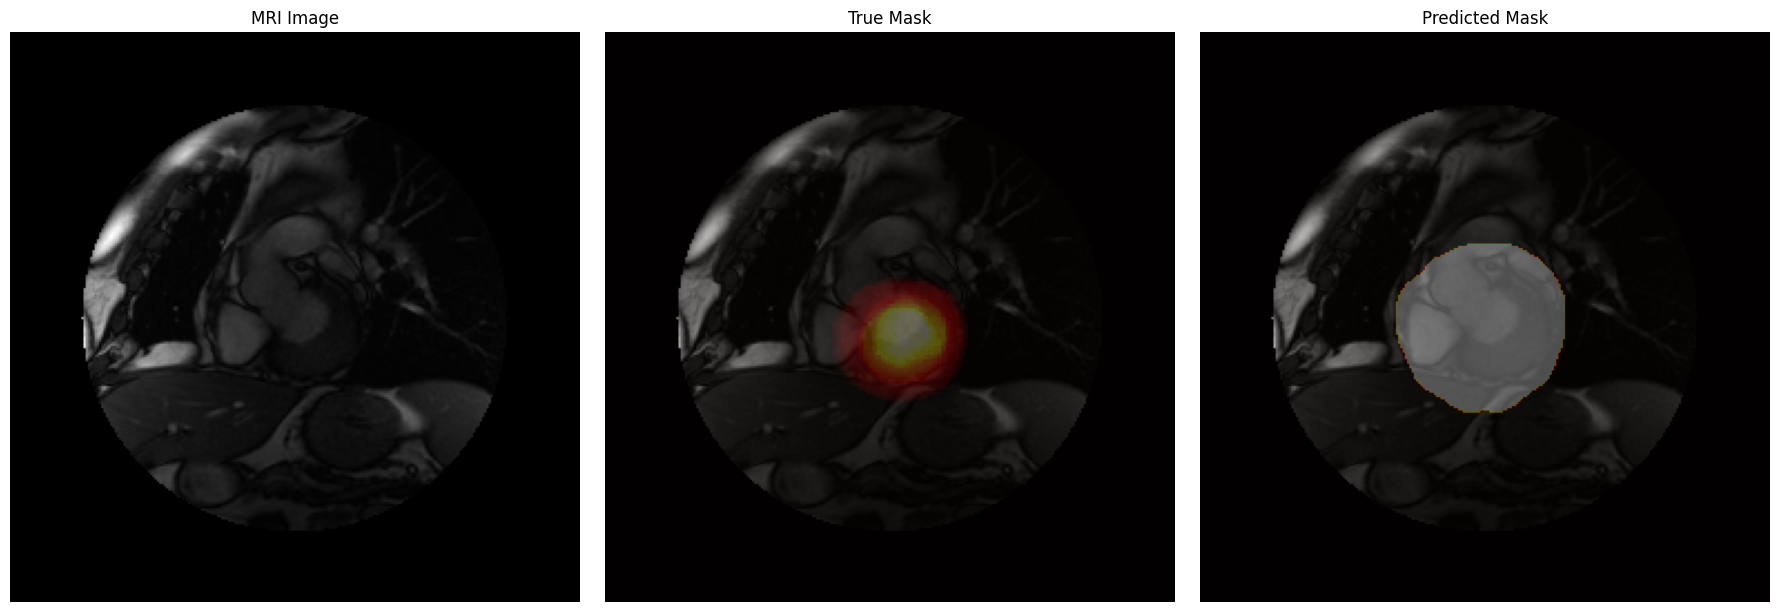

26
(tensor([0., 1.], device='cuda:0'), tensor([60787,  4749], device='cuda:0'))


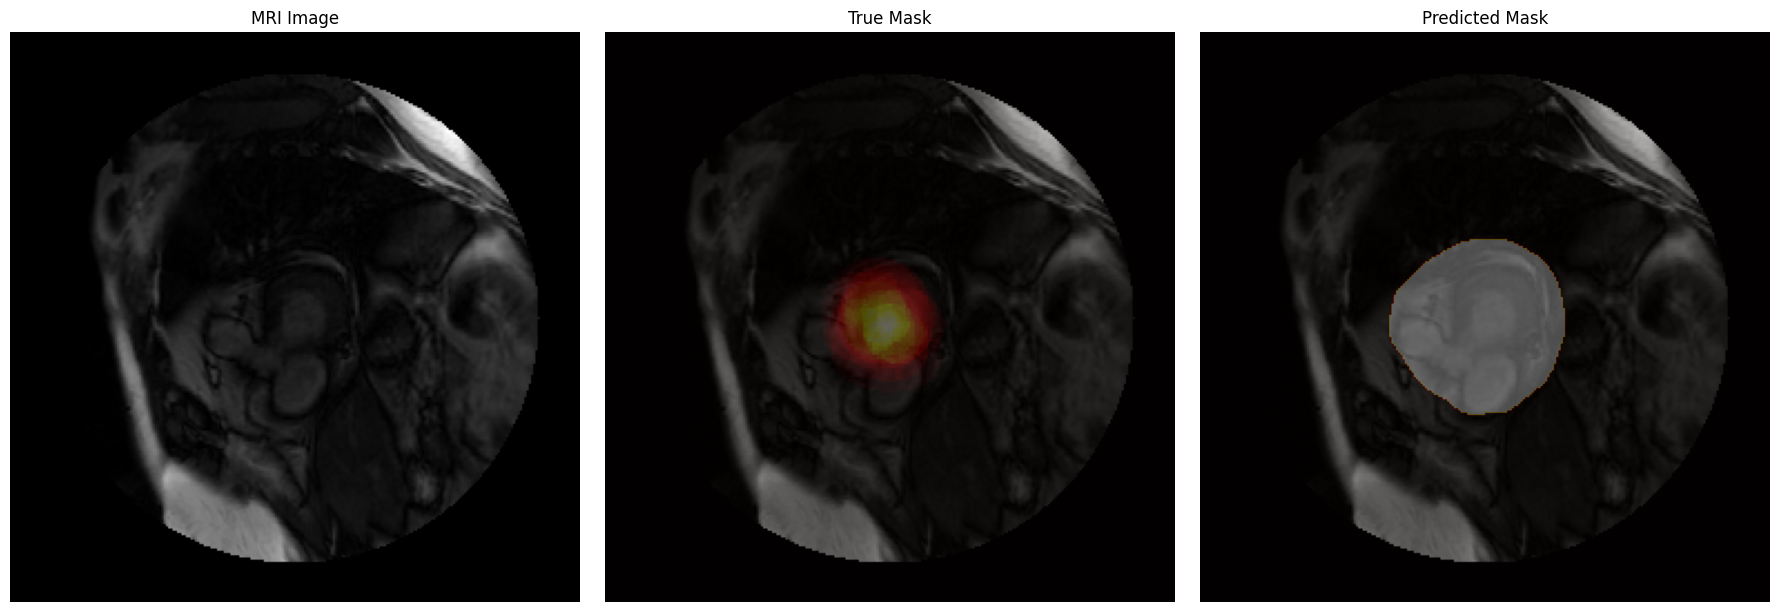

29
(tensor([0., 1.], device='cuda:0'), tensor([60715,  4821], device='cuda:0'))


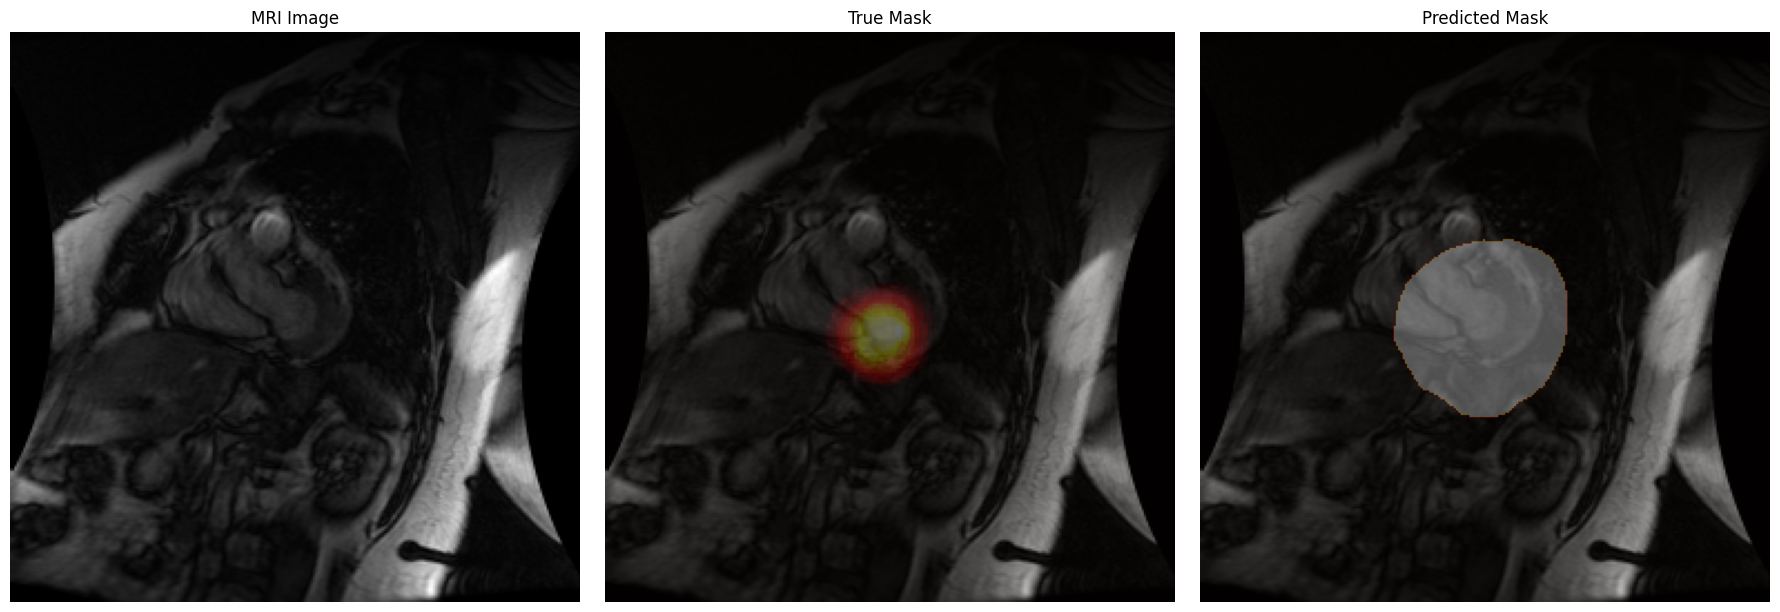

26
(tensor([0., 1.], device='cuda:0'), tensor([60600,  4936], device='cuda:0'))


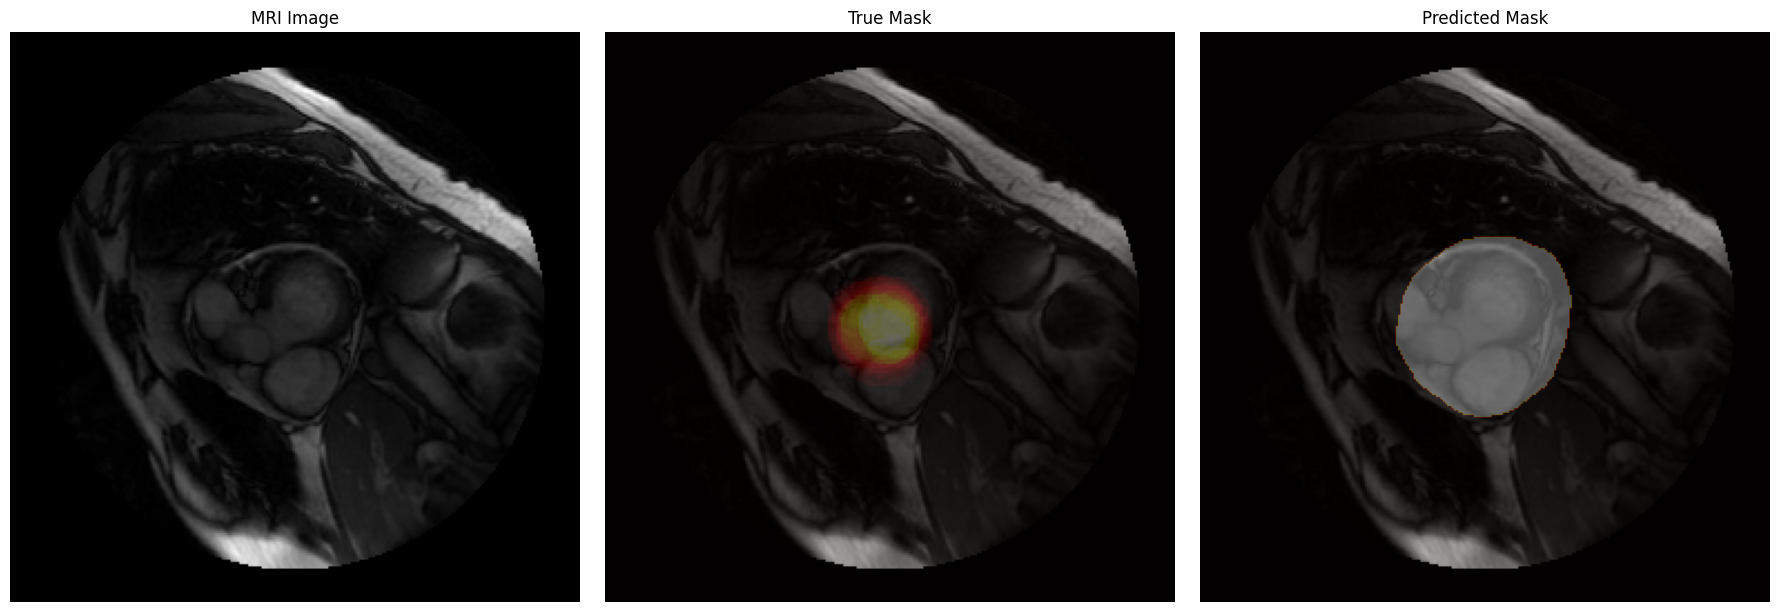

37
(tensor([0., 1.], device='cuda:0'), tensor([60044,  5492], device='cuda:0'))


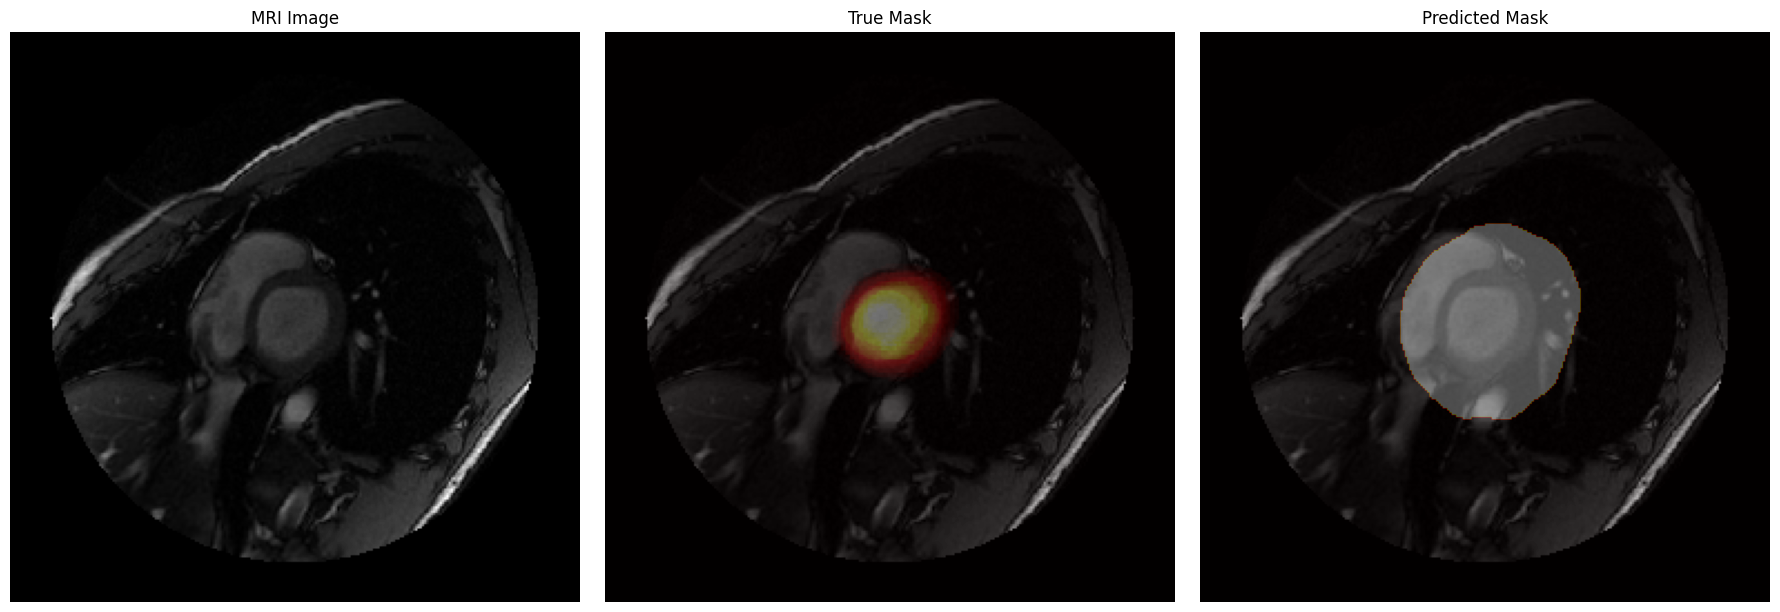

In [33]:
# similar to preprocess steps
def load_image_and_masks(patient_dir):
    image_path = os.path.join(patient_dir, 'images', os.listdir(os.path.join(patient_dir, 'images'))[0])
    image = pydicom.dcmread(image_path).pixel_array
    image = image.astype(np.float32) / image.max()
    image = ToTensor()(image)

    mask_paths = [os.path.join(patient_dir, 'masks', mask_file) for mask_file in os.listdir(os.path.join(patient_dir, 'masks'))]
    masks = [np.array(Image.open(mask_path)) for mask_path in mask_paths]
    masks = [mask.astype(np.float32) for mask in masks]
    masks = [torch.from_numpy(mask).float() for mask in masks]
    print(len(masks))

    return image, masks

def visualize_predictions(model, image, masks):
    model.eval()
    model.to('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        image_tensor = image.unsqueeze(0).unsqueeze(0).to('cuda' if torch.cuda.is_available() else 'cpu')
        outputs = model(image_tensor)
        probabilities = torch.sigmoid(outputs)  
        predictions = (probabilities >= 0.5).float() 
        predicted_mask = predictions.cpu().squeeze(0).numpy().squeeze(0)
        print(torch.unique(predictions,return_counts=True))


    # Combine masks
    true_mask_combined = sum(masks)

    # Plotting
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

    # MRI Image
    axs[0].imshow(image.squeeze(0), cmap='gray')
    axs[0].set_title('MRI Image')
    axs[0].axis('off')

    # True Mask
    axs[1].imshow(image.squeeze(0), cmap='gray')
    axs[1].imshow(true_mask_combined, cmap='hot', alpha=0.3)
    axs[1].set_title('True Mask')
    axs[1].axis('off')

    # Predicted Mask
    axs[2].imshow(image.squeeze(0), cmap='gray')
    axs[2].imshow(predicted_mask, cmap='hot', alpha=0.3)
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()


# Directory containing patient directories
base_dir = 'mask_and_mri_validation'

# Get a list of patient directories
patient_dirs = [os.path.join(base_dir, patient) for patient in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, patient))]

# Iterate over each patient directory
for patient_dir in patient_dirs:
    # Load the image and masks for the current patient
    image, masks = load_image_and_masks(patient_dir)
    
    # Visualize predictions for the current patient
    visualize_predictions(model, image, masks)




# The model predicts about 2000-3000 more 1s than a single true binary mask has. But they are clearly in the general area of interest
# I believe the positive weight might be influencing this increased number of 1s 